In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places

In [2]:
# set random see for reproducibility
RANDOM_SEED = 10


np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

# Read in data

In [3]:
input_data = pd.read_csv(os.path.dirname(os.getcwd())+'\\2_data_split\\traffic_speeds.csv')
input_data.head()

,1745,1747,417,1878,1604,1620,1447,1622,1407,2357,...,2047,2344,433,434,446,447,452,453,Time,Date
0,0.0769,0.0845,0.2062,0.1057,0.1786,0.1268,0.1084,0.0915,0.2150,0.1261,...,0.1637,0.0931,0.1293,0.1420,0.1748,0.1307,0.1183,0.0818,1,2011-01-01
1,0.0847,0.0739,0.1635,0.1015,0.1850,0.1142,0.1125,0.0931,0.1878,0.1550,...,0.1736,0.1030,0.1425,0.1455,0.1879,0.1213,0.0986,0.1244,2,2011-01-01
2,0.0870,0.0786,0.1406,0.1182,0.1716,0.1016,0.1015,0.0946,0.1613,0.1483,...,0.1839,0.1156,0.1232,0.1342,0.1776,0.1411,0.1394,0.1031,3,2011-01-01
3,0.0874,0.0801,0.1765,0.1168,0.1894,0.1245,0.1386,0.0905,0.2072,0.1417,...,0.1938,0.1323,0.1375,0.1472,0.1767,0.1373,0.1028,0.0941,4,2011-01-01
4,0.0874,0.0872,0.1561,0.1307,0.1697,0.1158,0.1153,0.0966,0.2616,0.1343,...,0.1858,0.1103,0.1353,0.1289,0.1683,0.1407,0.1310,0.1087,5,2011-01-01


In [4]:
input_data=input_data.ix[:,:-2]
input_data=np.array(input_data)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(5400, 22)


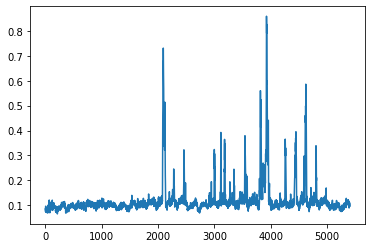

In [5]:
time = np.arange(0, 5400, 1)
print(input_data.shape)
plt.plot(time, input_data[:,0]) # Road 1745 as example

In [6]:
def create_dataset(data, time_steps):
    Xs, ys = [], []
    for i in range(len(data)-time_steps):
        # Reshape data from (time_steps,) to (time_steps, 1)
        Xs.append(np.reshape(data[i:(i+time_steps)], (time_steps, 1)))
        ys.append(data[i+time_steps])

    return np.array(Xs), np.array(ys)

In [7]:
Xs=[]
ys=[]
for i in range(input_data.shape[1]):
    x, y = create_dataset(input_data[:,i], time_steps=10) # Read in each road data
    Xs.append(x)
    ys.append(y)
    
Xs=np.array(Xs)
ys=np.array(ys)
print('The shape of X is {}, and the shape of y is {}.'.format(Xs.shape, ys.shape))


The shape of X is (22, 5390, 10, 1), and the shape of y is (22, 5390).


In [8]:
train_days=23
step=180
X_train, y_train = Xs[:,:train_days*step], ys[:,:train_days*step]
X_test, y_test = Xs[:,train_days*step:], ys[:,train_days*step:]
print('The shape of training X is {}, and the shape of training y is {}.'.format(X_train.shape, y_train.shape))
print('The shape of testing X is {}, and the shape of testing y is {}.'.format(X_test.shape, y_test.shape))

The shape of training X is (22, 4140, 10, 1), and the shape of training y is (22, 4140).
The shape of testing X is (22, 1250, 10, 1), and the shape of testing y is (22, 1250).


# LSTM Model

The idea is to train 22 roads as geographic infomation

In [20]:
def buildModel():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[2], X_train.shape[3])
    ))
    model.add(keras.layers.Dense(units=1))
    model.compile(
        loss='mean_squared_error',   # MSE error is used as the loss function in this regression task
        # We use the Adam optimizer to optimise the loss function for parameter training, 0.001 is the learning rate
        optimizer=keras.optimizers.Adam(0.001)  
    )
    return model

In [38]:
model=buildModel()
train_loss = []
validation_loss =[]
for i in range(X_train.shape[0]):
    history = model.fit(
        X_train[i], y_train[i],
        epochs=35,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        shuffle=False
    )
    train_loss.append(history.history['loss'])
    validation_loss.append(history.history['val_loss'])
    address='model'+str(i)+'.h5'
    model.save(address)
    model=buildModel()
    
    
# TODO init model

Train on 3726 samples, validate on 414 samples
Epoch 1/35
3726/3726 [==============================] - 8s 2ms/sample - loss: 0.0018 - val_loss: 0.0064
Epoch 2/35
3726/3726 [==============================] - 2s 656us/sample - loss: 9.7000e-04 - val_loss: 0.0045
Epoch 3/35
3726/3726 [==============================] - 2s 643us/sample - loss: 6.6263e-04 - val_loss: 0.0040
Epoch 4/35
3726/3726 [==============================] - 3s 762us/sample - loss: 5.7505e-04 - val_loss: 0.0036
Epoch 5/35
3726/3726 [==============================] - 2s 653us/sample - loss: 5.6025e-04 - val_loss: 0.0032
Epoch 6/35
3726/3726 [==============================] - 3s 722us/sample - loss: 5.3290e-04 - val_loss: 0.0030
Epoch 7/35
3726/3726 [==============================] - 3s 674us/sample - loss: 4.9777e-04 - val_loss: 0.0027
Epoch 8/35
3726/3726 [==============================] - ETA: 0s - loss: 4.6351e-0 - 2s 664us/sample - loss: 4.6203e-04 - val_loss: 0.0025
Epoch 9/35
3726/3726 [=============================

3726/3726 [==============================] - 3s 696us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 3/35
3726/3726 [==============================] - 3s 749us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 4/35
3726/3726 [==============================] - 3s 687us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 5/35
3726/3726 [==============================] - 3s 700us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 6/35
3726/3726 [==============================] - 3s 683us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 7/35
3726/3726 [==============================] - 2s 662us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 8/35
3726/3726 [==============================] - 3s 755us/sample - loss: 0.0010 - val_loss: 0.0010
Epoch 9/35
3726/3726 [==============================] - 3s 783us/sample - loss: 0.0010 - val_loss: 9.6502e-04
Epoch 10/35
3726/3726 [==============================] - 3s 718us/sample - loss: 9.7316e-04 - val_loss: 9.3521e-04
Epoch 11/35
3726/3726 [=====================

3726/3726 [==============================] - 3s 686us/sample - loss: 0.0034 - val_loss: 0.0020
Epoch 5/35
3726/3726 [==============================] - 3s 700us/sample - loss: 0.0033 - val_loss: 0.0020
Epoch 6/35
3726/3726 [==============================] - 3s 745us/sample - loss: 0.0031 - val_loss: 0.0019
Epoch 7/35
3726/3726 [==============================] - 3s 745us/sample - loss: 0.0028 - val_loss: 0.0018
Epoch 8/35
3726/3726 [==============================] - 3s 681us/sample - loss: 0.0026 - val_loss: 0.0017
Epoch 9/35
3726/3726 [==============================] - 3s 703us/sample - loss: 0.0025 - val_loss: 0.0016
Epoch 10/35
3726/3726 [==============================] - 3s 680us/sample - loss: 0.0024 - val_loss: 0.0016
Epoch 11/35
3726/3726 [==============================] - 3s 713us/sample - loss: 0.0022 - val_loss: 0.0015
Epoch 12/35
3726/3726 [==============================] - 3s 760us/sample - loss: 0.0022 - val_loss: 0.0014
Epoch 13/35
3726/3726 [==============================]

Epoch 9/35
3726/3726 [==============================] - 3s 760us/sample - loss: 0.0021 - val_loss: 7.8930e-04
Epoch 10/35
3726/3726 [==============================] - 3s 775us/sample - loss: 0.0020 - val_loss: 7.7670e-04
Epoch 11/35
3726/3726 [==============================] - 3s 747us/sample - loss: 0.0020 - val_loss: 7.6816e-04
Epoch 12/35
3726/3726 [==============================] - 3s 740us/sample - loss: 0.0020 - val_loss: 7.6236e-04
Epoch 13/35
3726/3726 [==============================] - 3s 749us/sample - loss: 0.0020 - val_loss: 7.5735e-04
Epoch 14/35
3726/3726 [==============================] - 3s 749us/sample - loss: 0.0019 - val_loss: 7.4717e-04
Epoch 15/35
3726/3726 [==============================] - 3s 753us/sample - loss: 0.0019 - val_loss: 7.4070e-04
Epoch 16/35
3726/3726 [==============================] - 3s 742us/sample - loss: 0.0019 - val_loss: 7.3751e-04
Epoch 17/35
3726/3726 [==============================] - 3s 778us/sample - loss: 0.0019 - val_loss: 7.3617e-04
Ep

Epoch 11/35
3726/3726 [==============================] - 3s 820us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 12/35
3726/3726 [==============================] - 3s 824us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 13/35
3726/3726 [==============================] - 3s 829us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 14/35
3726/3726 [==============================] - 3s 850us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 15/35
3726/3726 [==============================] - 3s 835us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 16/35
3726/3726 [==============================] - 3s 914us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 17/35
3726/3726 [==============================] - 3s 881us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 18/35
3726/3726 [==============================] - 3s 857us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 19/35
3726/3726 [==============================] - 3s 914us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 20/35
3726/3726 [==============

3726/3726 [==============================] - 3s 821us/sample - loss: 9.0106e-04 - val_loss: 7.3102e-04
Epoch 16/35
3726/3726 [==============================] - 3s 813us/sample - loss: 8.9382e-04 - val_loss: 7.2265e-04
Epoch 17/35
3726/3726 [==============================] - 3s 819us/sample - loss: 8.8760e-04 - val_loss: 7.1570e-04
Epoch 18/35
3726/3726 [==============================] - 3s 794us/sample - loss: 8.8232e-04 - val_loss: 7.1006e-04
Epoch 19/35
3726/3726 [==============================] - 3s 797us/sample - loss: 8.7794e-04 - val_loss: 7.0558e-04
Epoch 20/35
3726/3726 [==============================] - 3s 800us/sample - loss: 8.7437e-04 - val_loss: 7.0216e-04
Epoch 21/35
3726/3726 [==============================] - 3s 895us/sample - loss: 8.7154e-04 - val_loss: 6.9966e-04s - loss: 8.6
Epoch 22/35
3726/3726 [==============================] - 3s 840us/sample - loss: 8.6937e-04 - val_loss: 6.9794e-04
Epoch 23/35
3726/3726 [==============================] - 3s 802us/sample - loss

3726/3726 [==============================] - 4s 967us/sample - loss: 0.0035 - val_loss: 0.0027
Epoch 17/35
3726/3726 [==============================] - 4s 980us/sample - loss: 0.0035 - val_loss: 0.0026 0s - loss: 0. - ETA: 0s - loss: 0.003
Epoch 18/35
3726/3726 [==============================] - 4s 964us/sample - loss: 0.0034 - val_loss: 0.0026
Epoch 19/35
3726/3726 [==============================] - 4s 961us/sample - loss: 0.0034 - val_loss: 0.0026 ETA: 0
Epoch 20/35
3726/3726 [==============================] - 4s 964us/sample - loss: 0.0034 - val_loss: 0.0026
Epoch 21/35
3726/3726 [==============================] - 4s 948us/sample - loss: 0.0034 - val_loss: 0.0026
Epoch 22/35
3726/3726 [==============================] - 4s 967us/sample - loss: 0.0034 - val_loss: 0.0026
Epoch 23/35
3726/3726 [==============================] - 4s 967us/sample - loss: 0.0034 - val_loss: 0.0026
Epoch 24/35
3726/3726 [==============================] - 4s 965us/sample - loss: 0.0034 - val_loss: 0.0026.003


3726/3726 [==============================] - 3s 922us/sample - loss: 5.1705e-04 - val_loss: 3.8650e-04
Epoch 19/35
3726/3726 [==============================] - 3s 884us/sample - loss: 5.0860e-04 - val_loss: 3.8469e-04
Epoch 20/35
3726/3726 [==============================] - 3s 903us/sample - loss: 5.0053e-04 - val_loss: 3.8285e-04
Epoch 21/35
3726/3726 [==============================] - 3s 920us/sample - loss: 4.9277e-04 - val_loss: 3.8105e-04
Epoch 22/35
3726/3726 [==============================] - 3s 903us/sample - loss: 4.8530e-04 - val_loss: 3.7931e-04
Epoch 23/35
3726/3726 [==============================] - 3s 911us/sample - loss: 4.7807e-04 - val_loss: 3.7767e-04
Epoch 24/35
3726/3726 [==============================] - 3s 897us/sample - loss: 4.7106e-04 - val_loss: 3.7612e-04
Epoch 25/35
3726/3726 [==============================] - 3s 900us/sample - loss: 4.6425e-04 - val_loss: 3.7469e-04
Epoch 26/35
3726/3726 [==============================] - 3s 887us/sample - loss: 4.5763e-04 

3726/3726 [==============================] - 3s 936us/sample - loss: 7.0403e-04 - val_loss: 6.7192e-04
Epoch 19/35
3726/3726 [==============================] - 3s 925us/sample - loss: 6.9707e-04 - val_loss: 6.6528e-04
Epoch 20/35
3726/3726 [==============================] - 4s 941us/sample - loss: 6.8911e-04 - val_loss: 6.5849e-04
Epoch 21/35
3726/3726 [==============================] - 3s 933us/sample - loss: 6.8333e-04 - val_loss: 6.5219e-04
Epoch 22/35
3726/3726 [==============================] - 3s 915us/sample - loss: 6.7637e-04 - val_loss: 6.4573e-04
Epoch 23/35
3726/3726 [==============================] - 3s 924us/sample - loss: 6.7177e-04 - val_loss: 6.3990e-04
Epoch 24/35
3726/3726 [==============================] - 4s 941us/sample - loss: 6.6554e-04 - val_loss: 6.3383e-04
Epoch 25/35
3726/3726 [==============================] - 3s 936us/sample - loss: 6.6227e-04 - val_loss: 6.2863e-04
Epoch 26/35
3726/3726 [==============================] - 3s 938us/sample - loss: 6.5632e-04 

3726/3726 [==============================] - 3s 909us/sample - loss: 0.0014 - val_loss: 0.0101
Epoch 20/35
3726/3726 [==============================] - 3s 905us/sample - loss: 0.0014 - val_loss: 0.0098
Epoch 21/35
3726/3726 [==============================] - 3s 916us/sample - loss: 0.0014 - val_loss: 0.0095
Epoch 22/35
3726/3726 [==============================] - 3s 917us/sample - loss: 0.0014 - val_loss: 0.0092
Epoch 23/35
3726/3726 [==============================] - 3s 918us/sample - loss: 0.0014 - val_loss: 0.0088
Epoch 24/35
3726/3726 [==============================] - 3s 898us/sample - loss: 0.0014 - val_loss: 0.0084
Epoch 25/35
3726/3726 [==============================] - 3s 922us/sample - loss: 0.0014 - val_loss: 0.0080
Epoch 26/35
3726/3726 [==============================] - 3s 917us/sample - loss: 0.0013 - val_loss: 0.0077
Epoch 27/35
3726/3726 [==============================] - 3s 901us/sample - loss: 0.0013 - val_loss: 0.0074
Epoch 28/35
3726/3726 [==========================

3726/3726 [==============================] - 4s 1ms/sample - loss: 0.0013 - val_loss: 6.5646e-04- - ETA: 3s - loss: 5.1 -  - ETA: 1s - loss: 7.2808e- - ETA: 1s - loss: - ETA: 0s - loss: 
Epoch 17/35
3726/3726 [==============================] - 4s 1ms/sample - loss: 0.0012 - val_loss: 5.8249e-04
Epoch 18/35
3726/3726 [==============================] - 4s 1ms/sample - loss: 0.0013 - val_loss: 6.4142e-04- ETA: 0s - l
Epoch 19/35
3726/3726 [==============================] - 4s 1ms/sample - loss: 0.0012 - val_loss: 5.7746e-04
Epoch 20/35
3726/3726 [==============================] - 4s 1ms/sample - loss: 0.0012 - val_loss: 6.3032e-04TA: 2s - loss: 6.5294e  - ETA: 0s - loss
Epoch 21/35
3726/3726 [==============================] - 4s 1ms/sample - loss: 0.0011 - val_loss: 5.7597e-04- - ETA: 3s - loss: 5.7051e - E - ETA - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.00
Epoch 22/35
3726/3726 [==============================] - 4s 1ms/sample - loss: 0.0012 - val_loss: 6.2554e-04 2s - loss: 5. - ETA: 2

In [39]:
train_loss=np.array(train_loss)
validation_loss=np.array(validation_loss)

In [40]:
train_loss_mean=np.mean(train_loss,axis=0)
validation_loss_meam=np.mean(validation_loss,axis=0)
print(train_loss_mean)
print(validation_loss_meam)

[0.00366354 0.00227906 0.00201712 0.00188958 0.00179788 0.00173112
 0.00165453 0.00160156 0.00154294 0.00150477 0.00146239 0.00143638
 0.00140484 0.00138718 0.00136375 0.00135237 0.0013349  0.00132758
 0.00131394 0.0013096  0.00129928 0.0012972  0.00128873 0.00128818
 0.00128026 0.00128066 0.00127274 0.00127477 0.0012672  0.00127136
 0.00126407 0.00126783 0.00126137 0.00126215 0.00126026]
[0.00692213 0.00520303 0.00412425 0.00372353 0.00339395 0.00308457
 0.00279169 0.00258482 0.0024376  0.00236387 0.00233251 0.00234149
 0.00234197 0.0023379  0.00230594 0.00226646 0.00221813 0.00218156
 0.00214971 0.00213134 0.00211133 0.00209488 0.00207153 0.00205311
 0.00203245 0.00201292 0.00199348 0.00198109 0.0019732  0.0019712
 0.00197218 0.001973   0.00197584 0.00197852 0.0019726 ]


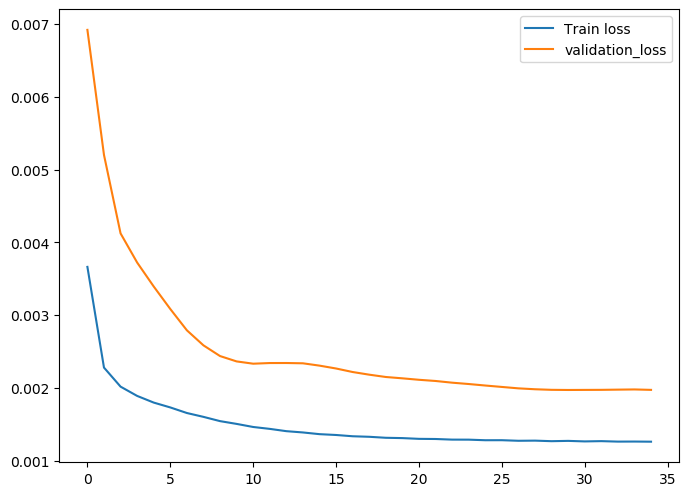

In [41]:
# Not very correct need to further research
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(train_loss_mean, label='Train loss')
plt.plot(validation_loss_meam, label='validation_loss')
plt.legend()

In [42]:
result_LSTM=[]
for i in range(X_train.shape[0]):
    address='model'+str(i)+'.h5'
    model=keras.models.load_model(address)
    y_predLSTM = model.predict(X_test[i]) #Predict result of each road
    result_LSTM.append(y_predLSTM)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [43]:
result_LSTM=np.array(result_LSTM)


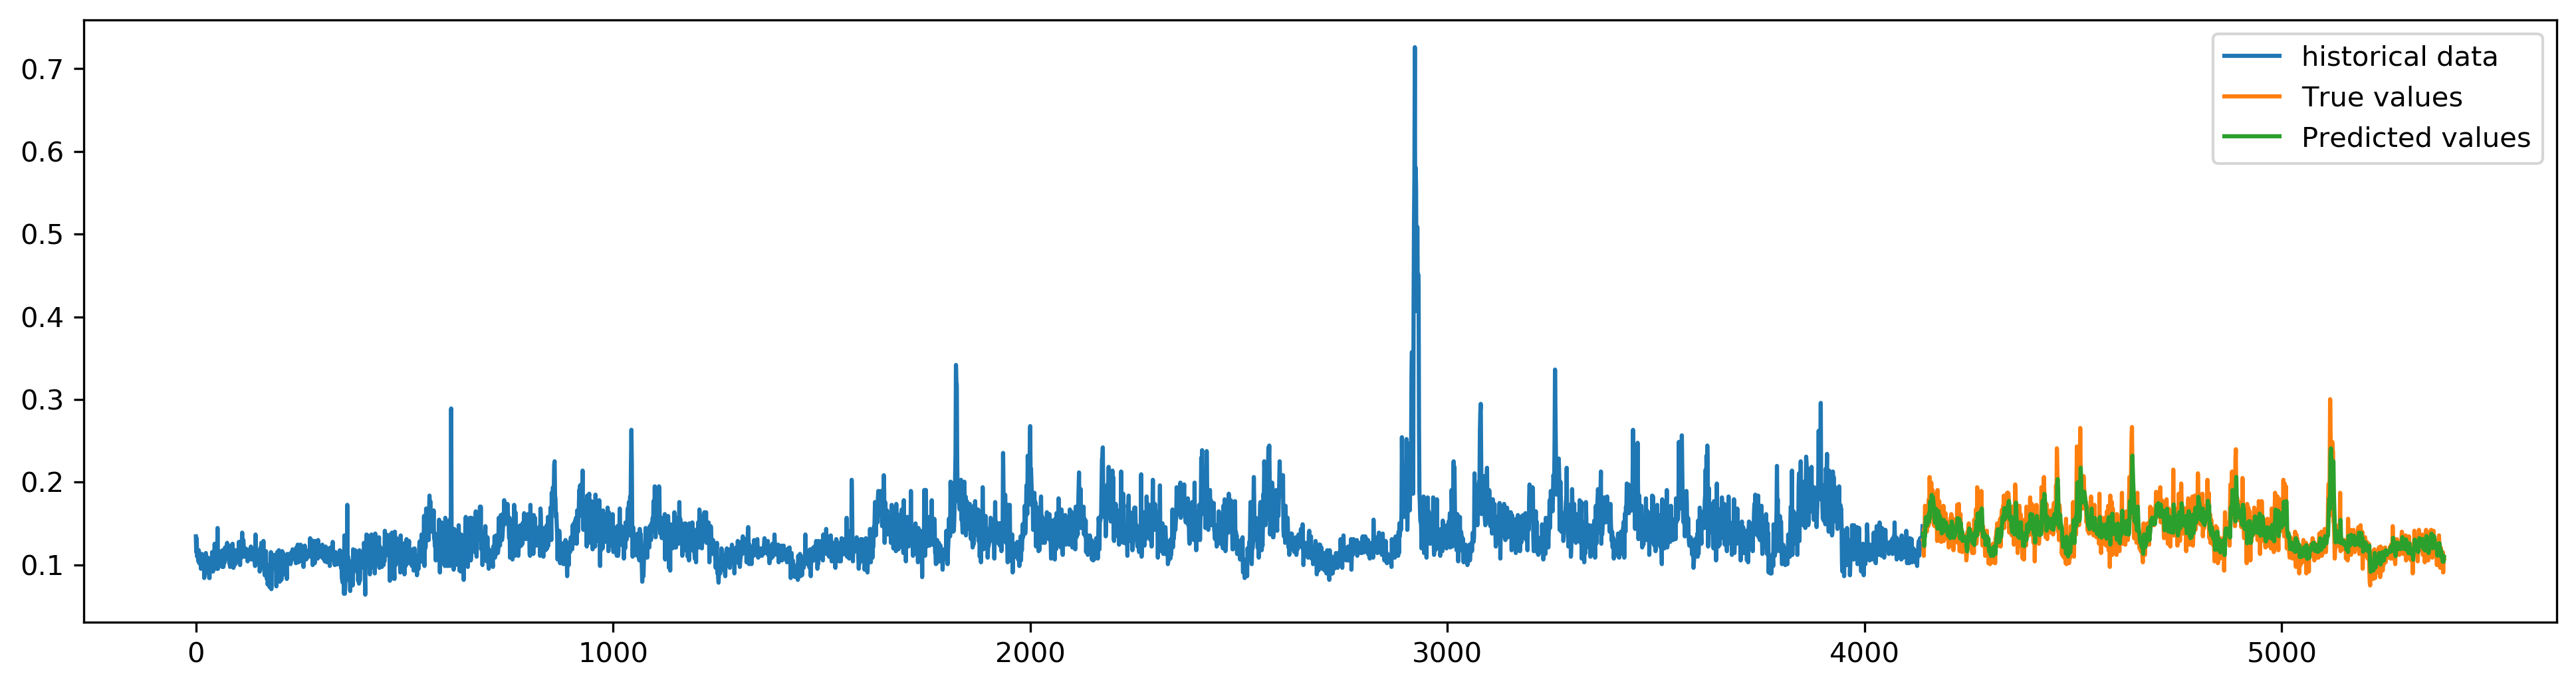

In [44]:
# plot the traffic of one road
road=21
plt.figure(figsize=(16, 4), dpi=300)
plt.plot(y_train[road], label='historical data')
plt.plot(list(range(len(y_train[road]), len(y_train[road])+len(y_test[road]))), y_test[road], label='True values')
plt.plot(list(range(len(y_train[road]), len(y_train[road])+len(y_test[road]))), result_LSTM[road], label='Predicted values')
plt.legend()

In [45]:
print(result_LSTM.shape)
heatmap_LSTM=result_LSTM.reshape(22,-1)

(22, 1250, 1)


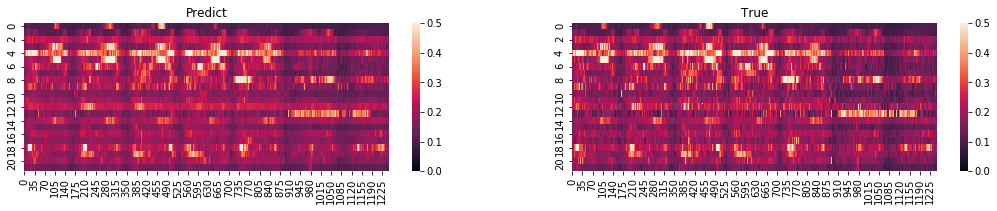

In [46]:
# Heat map
import seaborn as sns

fig = plt.figure(figsize=(18, 6))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
plt.sca(ax1)
sns_plot_pre = sns.heatmap(heatmap_LSTM,vmin=0,vmax=0.5)
plt.title('Predict')
plt.sca(ax2)
sns_plot_test = sns.heatmap(y_test,vmin=0,vmax=0.5)
plt.title('True')

plt.show()

# RF

In [47]:
# Reshape to RF data format
X_trainRF=X_train.reshape(22,-1,10)
X_testRF=X_test.reshape(22,-1,10)
y_trainRF=y_train

In [48]:
print(X_trainRF.shape)

(22, 4140, 10)


In [49]:
from sklearn.ensemble import RandomForestRegressor

result_RF=[]
for i in range (X_trainRF.shape[0]):
    clf_RF=RandomForestRegressor(max_depth=5,n_estimators=140,n_jobs=6)
    clf_RF.fit(X_trainRF[i], y_trainRF[i])
    y_predRF=clf_RF.predict(X_testRF[i])
    result_RF.append(y_predRF)


In [50]:
result_RF=np.array(result_RF)

In [51]:
result_RF.shape

(22, 1250)

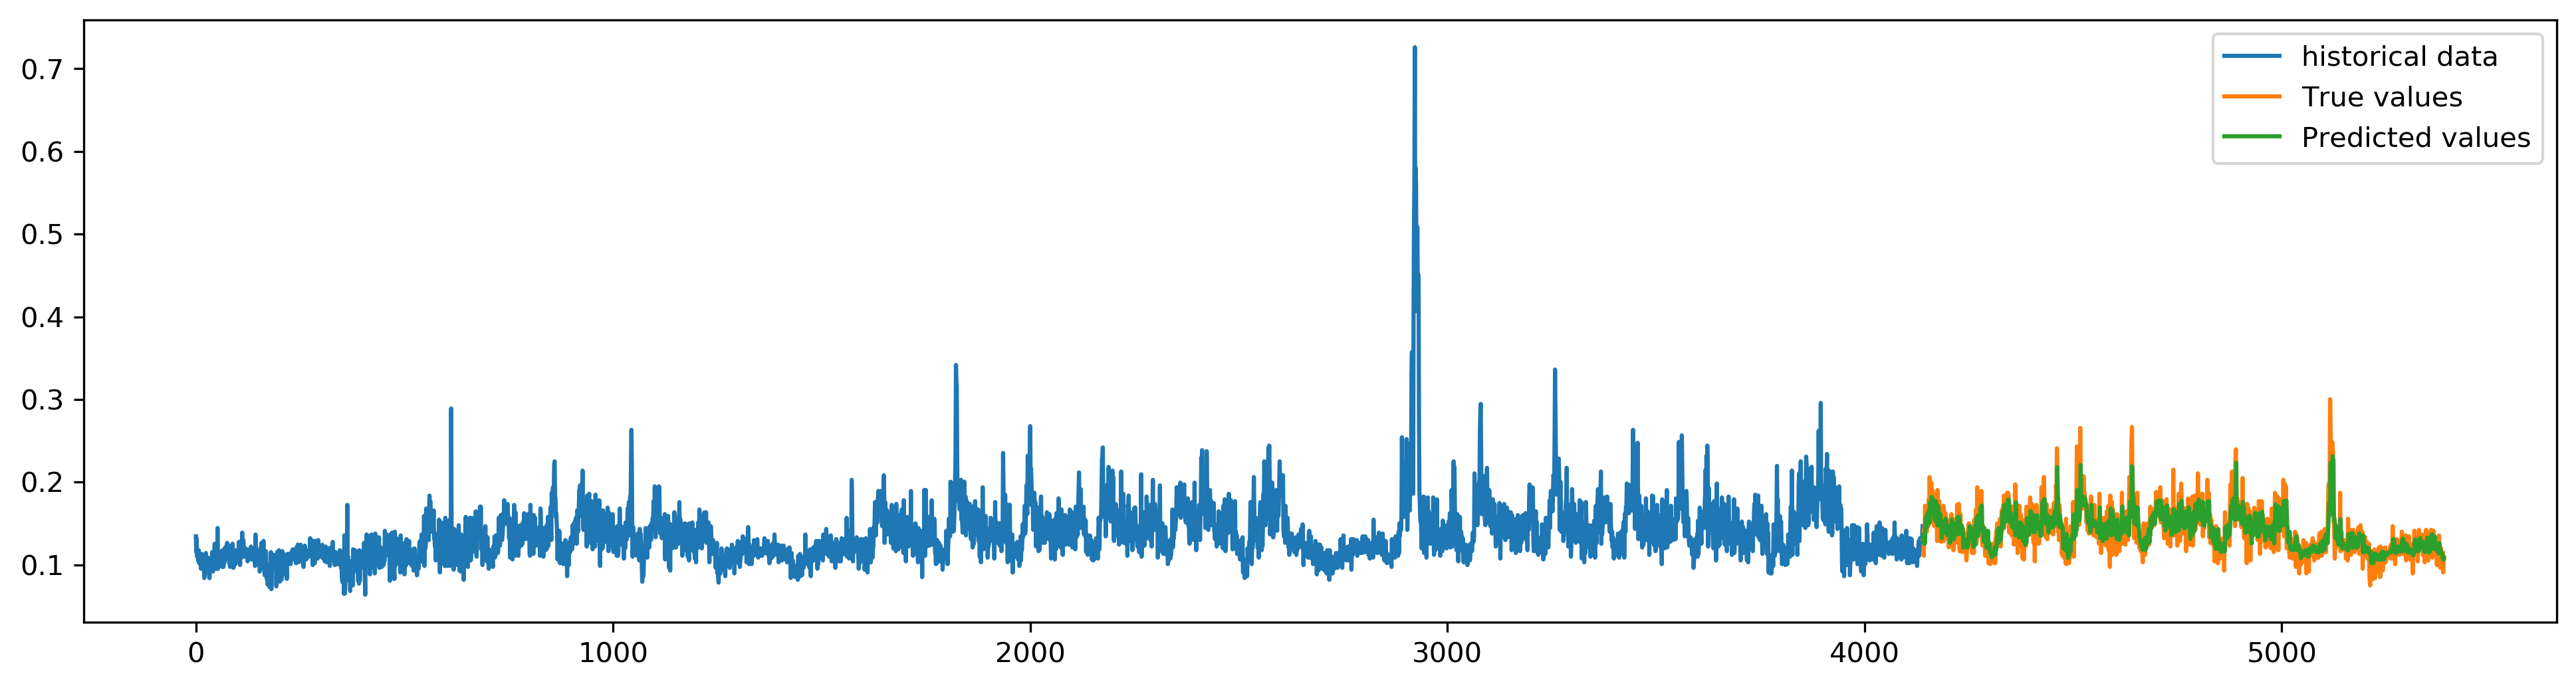

In [52]:
Road=21
plt.figure(figsize=(16, 4), dpi=300)
plt.plot(y_train[road], label='historical data')
plt.plot(list(range(len(y_train[Road]), len(y_train[Road])+len(y_test[Road]))), y_test[Road], label='True values')
plt.plot(list(range(len(y_train[Road]), len(y_train[Road])+len(y_test[Road]))), result_RF[Road], label='Predicted values')
plt.legend()

In [56]:
from sklearn.metrics import mean_squared_error

# Not very correct, need to further research
mse_LSTM=[]
mse_RF=[]

for i in range (result_LSTM.shape[0]):
    mse_LSTM.append(mean_squared_error(result_LSTM[i],y_test[i]))
    mse_RF.append(mean_squared_error(result_RF[i],y_test[i]))
    
print('LSTM:',np.mean(mse_LSTM))
print('RF:',np.mean(mse_RF))

LSTM: 0.0015730692115536258
RF: 0.0015515081355056825


In [55]:
from sklearn.metrics import r2_score

mse_LSTM=[]
mse_RF=[]

for i in range (result_LSTM.shape[0]):
    mse_LSTM.append(r2_score(result_LSTM[i],y_test[i]))
    mse_RF.append(r2_score(result_RF[i],y_test[i]))
    
print('LSTM:',np.mean(mse_LSTM))
print('RF:',np.mean(mse_RF))

LSTM: 0.362318270711445
RF: 0.3041307543704272


In [57]:
heatmap_LSTM=result_LSTM.reshape(22,-1)
heatmap_RF=result_RF.reshape(22,-1)

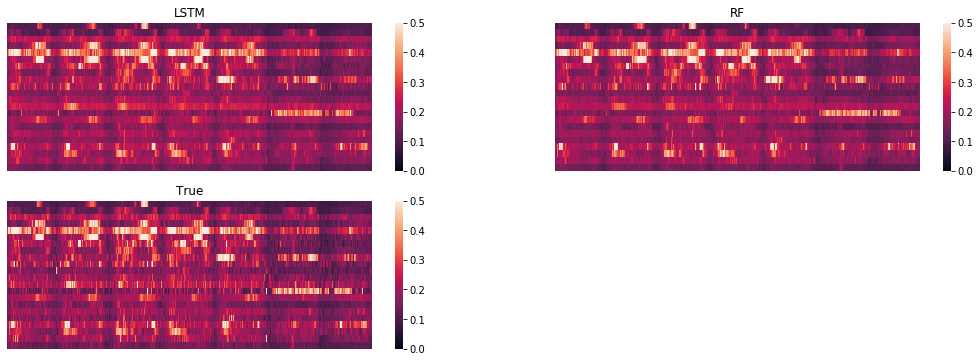

In [58]:
# Heat map
import seaborn as sns

fig = plt.figure(figsize=(18, 6))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
plt.sca(ax1)
sns_plot_pre = sns.heatmap(heatmap_LSTM,vmin=0,vmax=0.5,xticklabels=False,yticklabels=False)
plt.title('LSTM')
plt.sca(ax2)
sns_plot_pre = sns.heatmap(heatmap_RF,vmin=0,vmax=0.5,xticklabels=False,yticklabels=False)
plt.title('RF')
plt.sca(ax3)
sns_plot_test = sns.heatmap(y_test,vmin=0,vmax=0.5,xticklabels=False,yticklabels=False)
plt.title('True')

plt.show()